# Retreival System

This is based heavily on the tutorial from https://huggingface.co/learn/cookbook/en/advanced_rag as recommended in the course. We should probably credit it.

In [12]:
!pip install -q langchain langchain-community transformers sentence-transformers faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.2 MB/s eta 0:00:00


In [17]:
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
import pandas as pd

In [66]:
# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used for embeddings
print(f"Model's maximum sequence length: {SentenceTransformer('all-mpnet-base-v2').max_seq_length}")

Model's maximum sequence length: 384


In [70]:
# Load data
df = pd.read_csv('general_info.csv')

# Initialize embeddings
# embeddings = HuggingFaceEmbeddings(model_name='sentence-transformers/all-mpnet-base-v2')
embedding_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2",
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

# Split text into chunks
TEXT_SEPARATORS = [
    "\n\n",
    "\n",
    "."
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=384-64, # selected to stay under 384 max size for all-mpnet-base-v2
    chunk_overlap=50, # arbitrarily pick how much across chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=TEXT_SEPARATORS,
)
texts = []
metadatas = []

for _, row in df.iterrows():
    try:
      chunks = text_splitter.split_text(row['text'])
      texts.extend(chunks)
      metadatas.extend([{'source': row['source']}] * len(chunks))
    except:
      print(f"source {row['source']} corrupted")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


source https://onestoppgh.pittsburghpa.gov/pghprod/pub/lms/Login.aspx corrupted
source https://www.cmu.edu/dietrich/rss-feeds/news-rss.rss corrupted


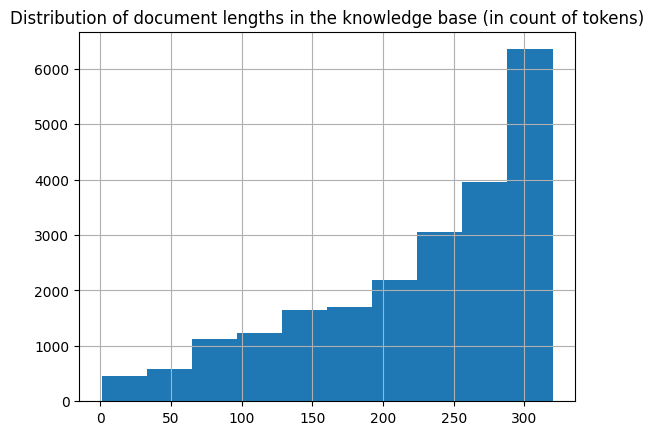

In [71]:
lengths = [len(text) for text in texts]

# Plot the distribution of text lengths, counted as the number of tokens
import matplotlib.pyplot as plt
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [72]:
# Create FAISS index
vectorstore = FAISS.from_texts(texts, embeddings, metadatas=metadatas, distance_strategy=DistanceStrategy.COSINE)

In [73]:
# Define retrieval function
def retrieve_top_k(query, k=5):
    results = vectorstore.similarity_search(query, k=k)
    return [(res.page_content, res.metadata['source']) for res in results]

In [81]:
# Example usage
query = "How many championships have the Penguins won?"
top_chunks = retrieve_top_k(query, k=5)
for i, (text, source) in enumerate(top_chunks, 1):
    print(f"\nResult {i}:")
    print(f"Source: {source}")
    print(f"Text: {text}\n")


Result 1:
Source: https://en.wikipedia.org/wiki/Pittsburgh_Penguins
Text: Penguins winning three (2008 Eastern Conference Finals, 4–1; 2009 Eastern Conference Quarterfinals, 4–2; and 2018 Eastern Conference First Round, 4–2).


Result 2:
Source: https://en.wikipedia.org/wiki/Pittsburgh_Penguins
Text: Founded during the 1967 expansion, the Penguins have qualified for six Stanley Cup Finals, winning the Stanley Cup five times – in 1991, 1992, 2009, 2016, and 2017. Along with the Edmonton Oilers, the Penguins are tied for the most Stanley Cup championships among the non-Original Six teams and sixth overall


Result 3:
Source: https://en.wikipedia.org/wiki/Pittsburgh_Penguins
Text: lers (ECHL)Stanley Cups5 (1990–91, 1991–92, 2008–09, 2015–16, 2016–17)Conference championships6 (1990–91, 1991–92, 2007–08, 2008–09, 2015–16, 2016–17)Presidents' Trophy1 (1992–93)Division championships9 (1990–91, 1992–93, 1993–94, 1995–96, 1997–98, 2007–08, 2012–13, 2013–14, 2020–21)Official websitenhl.com/peng